<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow prat 3: Scaling up

We'll be scaling up to all 101 classes of food.

Our goal is to outperform the original Food101 paper (50.76%) with 10% of training data

https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

In [1]:
!nvidia-smi

Mon Oct 30 10:10:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks we've created series of helper functions. Now we're going to import them

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-30 10:10:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-30 10:10:56 (91.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions into our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data

10% of the training data, let's download it.

In [4]:
# Get the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# Unzip the data
unzip_data("101_food_classes_10_percent.zip") # without .zip produces error

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-10-30 10:11:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.207, 74.125.202.207, 74.125.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   130MB/s    in 13s     

2023-10-30 10:11:14 (118 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beet_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle the test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes dataset

StepsŁ
1. Setup a model checkpoint callback
2. Create a data augmentation layer to build data augmentation right into the model
3. Build a headless Functional EfficientNetB0 backboned model
4. Compile the model
5. Feature extract for 5 epochs and validate on 15% of the test data


In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
# Create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation as a layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(.2),
    preprocessing.RandomHeight(.2),
    preprocessing.RandomWidth(.2),
    preprocessing.RandomZoom(.2),
    # preprocessing.Rescale(1./255.) #when using EfficientNet not needed
], name="data_augmentation")

In [9]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable output layer
inputs = layers.Input(shape=(224, 224, 3), name="input")
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # in inference mode - stays frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
outputs = layers.Dense(len(train_data_10_percent.class_names),
                       activation="softmax",
                       name="output")(x)
model = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 0s 0us/step


In [10]:
# Get the summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool (GlobalAve  (None, 1280)              0         
 ragePooling2D)                                                  
                                                                 
 output (Dense)              (None, 101)               129381    
                                                             

In [11]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [12]:
# Fit
history_1 = model.fit(train_data_10_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)),
                      callbacks=[create_tensorboard_callback("experiments","10_percent_data"), checkpoint_callback])

Saving TensorBoard log files to: experiments/10_percent_data/20231030-101142
Epoch 1/5
237/237 [==============================] - 127s 470ms/step - loss: 3.3845 - accuracy: 0.2779 - val_loss: 2.5243 - val_accuracy: 0.4399
Epoch 2/5
237/237 [==============================] - 86s 360ms/step - loss: 2.1972 - accuracy: 0.4990 - val_loss: 2.0405 - val_accuracy: 0.5011
Epoch 3/5
237/237 [==============================] - 70s 293ms/step - loss: 1.8268 - accuracy: 0.5653 - val_loss: 1.8847 - val_accuracy: 0.5201
Epoch 4/5
237/237 [==============================] - 64s 266ms/step - loss: 1.5985 - accuracy: 0.6125 - val_loss: 1.7957 - val_accuracy: 0.5320
Epoch 5/5
237/237 [==============================] - 59s 248ms/step - loss: 1.4548 - accuracy: 0.6451 - val_loss: 1.7406 - val_accuracy: 0.5445


In [13]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 65s 82ms/step - loss: 1.5665 - accuracy: 0.5910


[1.5665022134780884, 0.5910494923591614]

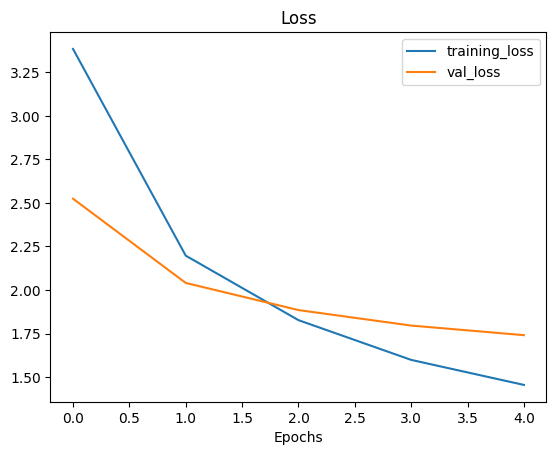

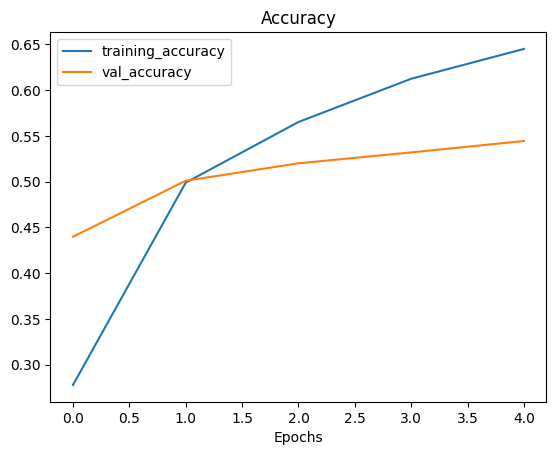

In [14]:
plot_loss_curves(history_1)

Overfitting HA!

## Fine Tuning

In [17]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze the bottom layers except the top 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [18]:
# Recompile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #10x lower lr
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [19]:
# Which layers are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input True
data_augmentation True
efficientnetb0 True
global_avg_pool True
output True


In [21]:
# Which layers are trainable in our base_model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [23]:
# Fit the model
initial_epochs = 5
total_epochs = initial_epochs + 5
history_2 = model.fit(train_data_10_percent,
                      epochs=total_epochs,
                      initial_epoch=history_1.epoch[-1],
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)))

Epoch 5/10
237/237 [==============================] - 49s 204ms/step - loss: 1.0352 - accuracy: 0.7249 - val_loss: 1.6941 - val_accuracy: 0.5514
Epoch 6/10
237/237 [==============================] - 50s 210ms/step - loss: 0.9590 - accuracy: 0.7464 - val_loss: 1.6904 - val_accuracy: 0.5548
Epoch 7/10
237/237 [==============================] - 52s 217ms/step - loss: 0.8982 - accuracy: 0.7599 - val_loss: 1.6787 - val_accuracy: 0.5538
Epoch 8/10
237/237 [==============================] - 54s 227ms/step - loss: 0.8521 - accuracy: 0.7735 - val_loss: 1.6555 - val_accuracy: 0.5638
Epoch 9/10
237/237 [==============================] - 45s 188ms/step - loss: 0.7997 - accuracy: 0.7851 - val_loss: 1.7009 - val_accuracy: 0.5495
Epoch 10/10
237/237 [==============================] - 46s 193ms/step - loss: 0.7454 - accuracy: 0.8026 - val_loss: 1.7225 - val_accuracy: 0.5495


In [24]:
# Evaluate on the whole data
results_2 = model.evaluate(test_data)
results_2

790/790 [==============================] - 69s 87ms/step - loss: 1.5030 - accuracy: 0.6060


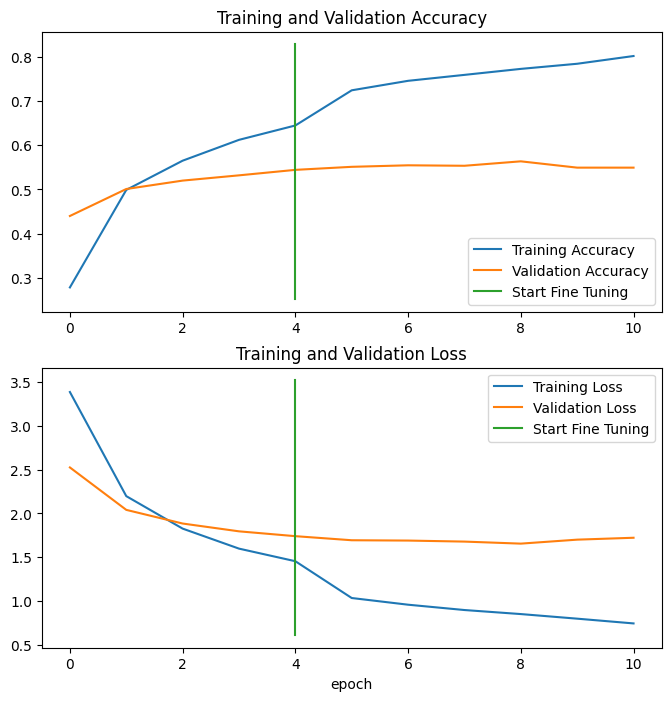

In [25]:
# Compare the histories
compare_historys(history_1, history_2, initial_epochs=5)

## Saving and loading our model

In [26]:
# Save the fine-tuned model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_saved_big_dog_model")

In [29]:
# Load and evaluate the whole model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_saved_big_dog_model")

In [30]:
# Evaluate the loaded model and compare to the pre saved one
results_2_1 = loaded_model.evaluate(test_data)
results_2_1

790/790 [==============================] - 68s 82ms/step - loss: 1.5030 - accuracy: 0.6060


[1.5030308961868286, 0.6059802174568176]

In [31]:
results_2

[1.5030308961868286, 0.6059802174568176]

## Evaluating the performance of the big dog model across all different classes

Make predictions and visualize them to find out which are the most wrong

In [32]:
import tensorflow as tf

# Importing Daniel's model to get the same results
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-10-30 10:49:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.207, 108.177.111.207, 142.250.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   158MB/s    in 0.3s    

2023-10-30 10:49:31 (158 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [33]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [34]:
model_mdb = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [35]:
# Evaluate loaded model
results_mdb = model_mdb.evaluate(test_data)
results_mdb

790/790 [==============================] - 70s 87ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making predictions with our trained model

In [36]:
# Making predictions with model
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 66s 82ms/step


In [37]:
# How many predictions are there
len(preds_probs)

25250

In [38]:
# What's the shape of a prediction
preds_probs[0].shape

(101,)

In [39]:
preds_probs[:10]

array([[1.51257008e-01, 6.79298595e-04, 1.47903502e-01, ...,
        6.56310840e-06, 1.24630518e-02, 8.52295011e-03],
       [8.91802192e-01, 9.59847881e-08, 1.96813187e-03, ...,
        3.44303343e-03, 5.68537928e-07, 1.16101837e-05],
       [3.17938268e-01, 7.15285689e-02, 1.16026625e-02, ...,
        2.76360370e-04, 2.73498270e-04, 2.55735777e-03],
       ...,
       [1.43158853e-01, 1.15280163e-05, 8.99905572e-04, ...,
        4.77225780e-02, 9.04470449e-04, 9.56599324e-05],
       [1.66715935e-01, 1.15781953e-03, 2.27405906e-01, ...,
        1.89901664e-04, 2.17304419e-04, 2.85085000e-04],
       [6.69141293e-01, 8.46285218e-07, 3.13828443e-03, ...,
        6.84063509e-03, 1.24098926e-06, 7.55205692e-04]], dtype=float32)

In [42]:
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([1.5125701e-01, 6.7929860e-04, 1.4790350e-01, 2.1900701e-07,
        4.7786943e-06, 8.9298840e-07, 4.4213255e-05, 8.5712742e-07,
        1.6490279e-02, 1.4404765e-04, 1.8490642e-06, 8.3572650e-06,
        2.6023161e-04, 2.2095510e-07, 1.0965243e-03, 2.4764768e-03,
        1.4057102e-05, 5.4210908e-04, 1.1050332e-02, 1.5179911e-05,
        4.8595485e-03, 1.2132550e-05, 5.8189580e-05, 3.0418496e-05,
        3.8196174e-03, 3.3262724e-03, 1.1617446e-03, 2.4484878e-05,
        1.5586737e-01, 6.3939992e-04, 8.8184100e-07, 4.6054687e-04,
        6.4685679e-04, 4.5015895e-07, 3.8728639e-02, 3.2925684e-06,
        7.6344164e-05, 1.6127687e-03, 1.0540682e-01, 7.4632007e-05,
        1.3021883e-03, 3.9081988e-03, 3.1165491e-04, 1.9732928e-05,
        1.3679698e-04, 7.9911997e-06, 6.7436846e-04, 4.3039682e-04,
        2.1988315e-06, 3.7635017e-02, 3.8358598e-04, 5.4571647e-05,
        8.6123422e-02, 1.5883777e-02, 1.2482844e-05, 1.5584098e-03,
        2.9723519e-02, 1.4711199e-03, 1.9378786e